In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
# zhfont = FontProperties(fname="/System/Library/Fonts/PingFang.ttc")

In [2]:
data = pd.read_csv("data/preprocessed.csv")
with open("data/SSDs.bin", "rb") as f:
    SSDs = pickle.load(f)

In [3]:
SSDs[0]

('白糖-锌', 2.0872542454386913)

In [4]:
data.head()

,date,asset,close,volume
0,2017-01-03,LLDPE,9710.0,415780.0
1,2017-01-03,PTA,5446.0,2106438.0
2,2017-01-03,动力煤,493.0,102390.0
3,2017-01-03,天然橡胶,18360.0,352158.0
4,2017-01-03,棉花,15085.0,184116.0


# 协整

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
# from statsmodels.formula.api import ols

In [10]:
def getPrice(data, asset, start, end):
    '''
    @Description
    获取名称为asset的前t价格序列
    ------------
    @Params
    data, DataFrame
    asset, str
    t, int
    ------------
    @Returns
    prices, array
    '''
    return data[data["asset"]==asset].sort_values(by=["date"]).iloc[start:end, 2].values

In [11]:
def getDPrice(data, asset, start, end):
    '''
    @Description
    获取一阶差分序列
    ------------
    @Params
    data, DataFrame
    asset, str
    t, int
    ------------
    @Returns
    prices, array
    '''
    temp = data[data["asset"]==asset].sort_values(by=["date"]).iloc[start:end, 2]
    return (temp - temp.shift(1)).dropna().values

In [9]:
# 指定形成期12个月
dates = np.sort(data["date"].unique())
# form_days = sum(dates<="2018-01-03")
# end_date = sum(dates<="2018-07-03")
start_date = sum(dates<="2018-01-01")
end_date = sum(dates<="2019-01-01")

In [1]:
alpha = 0.05  # 置信度水平
cn1 = 0  # 非单整
cn2 = 0  # 非一阶单整
cn4 = 0  # 未通过单位根检验
models = []
for idx, v in enumerate(SSDs):
    pairs, SSD = v
    pair1, pair2 = pairs.split("-")
    y = getPrice(data, pair1, start_date, end_date)
    x = getPrice(data, pair2, start_date, end_date)
    if np.mean(y)<np.mean(x):
        # y为价格较大的
        y, x = x, y
        pair1, pair2 = pair2, pair1
    # 单位根检验 pvalue
    p1 = adfuller(y)[1]
    p2 = adfuller(x)[1]
    if p1<alpha or p2<alpha:
        cn1 += 1
        # print(f"价格序列单位根检验 {pair1}:{p1:.4f}   {pair2}:{p2:.4f}")
        continue

    # 一阶差分单位根检验 pvalue
    p1 = adfuller(getDPrice(data, pair1, start_date, end_date))[1]
    p2 = adfuller(getDPrice(data, pair2, start_date, end_date))[1]
    if p1>alpha or p2>alpha:
        cn2 += 1
        # print(f"一阶差分序列单位根检验 {pair1}:{p1:.4f}   {pair2}:{p2:.4f}")
        continue

    # 检验协整关系
    # if coint(y, x, return_results=True)[1]<alpha:
    #     cn4+=1 

    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    result = model.fit()

    # print("回归结果")
    # print(result.summary())

    # 残差单位根检验
    pvalue = adfuller(result.resid)[1]
    # print(pvalue)
    if pvalue > alpha:
        cn4 += 1
        # print("不通过单位根检验", pvalue, pair1, pair2)
        continue
    models.append([idx, model, result])

In [66]:
# print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     758.6
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           7.77e-77
Time:                        01:06:43   Log-Likelihood:                -1540.8
No. Observations:                 246   AIC:                             3086.
Df Residuals:                     244   BIC:                             3093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2757.8627     90.038     30.630      0.0

In [14]:
print(len(models))

46


## 绘制图表

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

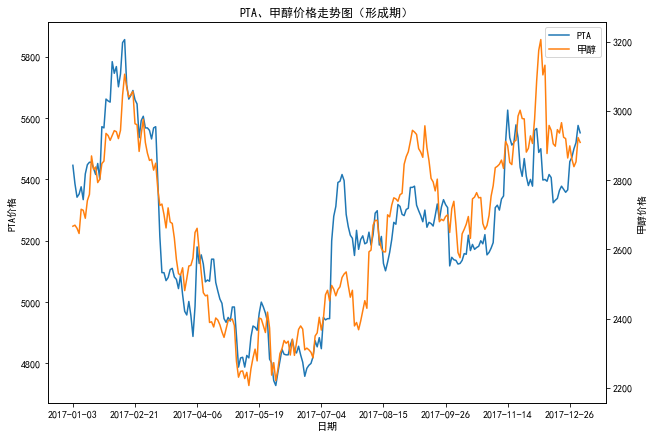

In [63]:
# 价格走势图
pair1 = "PTA"
pair2 = "甲醇"
fig, ax = plt.subplots(figsize=(10, 7))
d1 = data[data["asset"]==pair1].iloc[:form_days, :]
d2 = data[data["asset"]==pair2].iloc[:form_days, :]
line1 = ax.plot(d1.date, d1.close, label=pair1, c="#1f77b4")
ax2 = ax.twinx()
line2 = ax2.plot(d2.date, d2.close, label=pair2,c="#ff7f0e")
ax.legend(line1+line2, [pair1, pair2])
ax.set_xlabel(u"日期")
ax.set_ylabel(u"PTA价格")
ax2.set_ylabel("甲醇价格")
ax.set_title(f"{pair1}、{pair2}价格走势图（形成期）")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.savefig("PTA甲醇价格走势图形成期.jpg", dpi=300)
plt.show()

array(['2017-01-03', '2017-01-04', '2017-01-05', ..., '2021-06-02',
       '2021-06-03', '2021-06-04'], dtype=object)

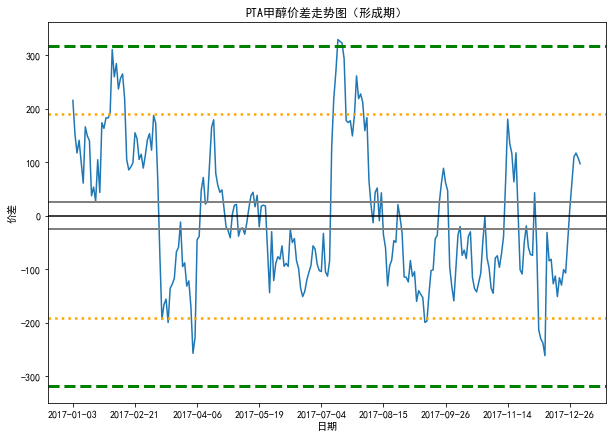

In [78]:
# 残差图
pair1 = "PTA"
pair2 = "甲醇"
fig, ax = plt.subplots(figsize=(10, 7))
# d1 = data[data["asset"]==pair1].iloc[:form_days, :]
# d2 = data[data["asset"]==pair2].iloc[:form_days, :]
x = dates[:form_days]
resid = result.resid
ax.plot(x, resid)
mu = np.mean(resid)
sd = np.std(resid)
ax.axhline(y=mu,color='black')
ax.axhline(y=mu+0.2*sd,color='gray',ls='-',lw=2)
ax.axhline(y=mu-0.2*sd,color='gray',ls='-',lw=2)
ax.axhline(y=mu+1.5*sd,color='orange',ls=':',lw=2.5)
ax.axhline(y=mu-1.5*sd,color='orange',ls=':',lw=2.5)
ax.axhline(y=mu+2.5*sd,color='green',ls='--',lw=3) 
ax.axhline(y=mu-2.5*sd,color='green',ls='--',lw=3) 
ax.set_title("PTA甲醇价差走势图（形成期）")
ax.set_ylabel("价差")
ax.set_xlabel("日期")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.savefig("PTA甲醇价差走势图形成期.jpg", dpi=300)
plt.show()

## 模型保存

In [15]:
# 保存
# with open("data/models.bin", "wb")as f:
#     pickle.dump(models, f)
#     f.close()   

In [16]:
with open("data/models.bin", "rb")as f:
    models = pickle.load(f)
    f.close()

In [17]:
len(models)

46